In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from dataset_pe import IterableSpectraDataset, collate_fn
from model_pe import Generator
from utils import get_config2, resolve_path
from glob import glob

In [2]:

# Function to load the configuration
def load_configurations():
    config = get_config2()
    dataset_name = config['dataset_name']
    dataset_config = config['datasets'][dataset_name]
    data_path = resolve_path(dataset_config['path'])
    checkpoints_path = resolve_path(config['paths']['checkpoints'])
    batch_size = config['training']['batch_size']
    return config, data_path, checkpoints_path, batch_size


In [3]:
# Function to prepare the dataset
def prepare_datasets(data_path, batch_size, yield_full_spectrum=True):
    dataset = IterableSpectraDataset(data_path, is_validation=False, yield_full_spectrum=yield_full_spectrum)
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    return data_loader

In [4]:
# Function to load the optimized latent codes from HDF5 file
def load_optimized_latent_codes(file_list):
    latent_codes = {}
    for file_path in file_list:
        with h5py.File(file_path, 'r') as f:
            for group_name in f.keys():
                group = f[group_name]
                if 'optimized_latent_code/latest' in group:
                    latent_codes[group_name] = torch.tensor(group['optimized_latent_code/latest'][:], dtype=torch.float32)
    return latent_codes


In [5]:
def generate_full_spectra(generator, latent_codes, batch):
    unique_ids = [uid.decode('utf-8') if isinstance(uid, bytes) else uid for uid in batch['spectrum_id']]
    valid_ids = [uid for uid in unique_ids if uid in latent_codes]
    latent_vectors = torch.stack([latent_codes[uid] for uid in valid_ids])
    generated_spectra = generator(latent_vectors, batch['wavelength'])
    return generated_spectra, valid_ids


In [6]:
def plot_spectra(batch, generated_spectra, valid_ids, num_spectra=10):
    wavelength_grid = batch['wavelength'][0].numpy()
    for i in range(min(num_spectra, len(valid_ids))):
        unique_id = valid_ids[i]
        index = batch['spectrum_id'].index(unique_id)
        flux_interpolated = batch['flux'][index].numpy()
        generated_flux = generated_spectra[i].detach().cpu().numpy()

        # Plot the original and generated spectra
        plt.figure(figsize=(10, 5))
        plt.plot(wavelength_grid, flux_interpolated, label='Original Flux', color='blue', alpha=0.7, linewidth=0.5)
        plt.plot(wavelength_grid, generated_flux, label='Generated Flux', color='red', alpha=0.7, linewidth=0.5)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        # Set xlim based on unique_id
        if '_apogee_' in unique_id:
            plt.xlim(15000, 17005)
        elif '_galah_' in unique_id:
            plt.xlim(4700, 7895)
        plt.title(f'Spectrum for ID: {unique_id}')
        plt.legend()
        plt.grid(True)
        plt.show()


In [7]:
print("Initializing device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading configurations...")
config, data_path, checkpoints_path, batch_size = load_configurations()


Initializing device...
Using device: cpu
Loading configurations...


In [8]:
print("Preparing datasets with full spectra...")
data_loader_full_spectra = prepare_datasets(data_path, batch_size, yield_full_spectrum=True)

print("Initializing model...")
generator = Generator(config['training']['latent_dim'], config['model']['output_dim'], config['model']['generator_layers'] ,  config['model']['max_wavelength'],  config['model']['activation_function'] ,  config['model']['pe_dim']).to(device)
generator.load_state_dict(torch.load(os.path.join(checkpoints_path, 'checkpoint_best.pth.tar'))['state_dict'])
generator.eval()


Preparing datasets with full spectra...
Initializing model...


Generator(
  (wavelength_encoder): RandGaus(
    (mapping): Linear(in_features=1, out_features=4, bias=False)
  )
  (model): Sequential(
    (0): Linear(in_features=24, out_features=24, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=24, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=256, out_features=200, bias=True)
  )
)

In [9]:
print("Loading optimized latent codes...")
file_list = glob(os.path.join(data_path, 'spectra_healpix_*.hdf5'))
latent_codes = load_optimized_latent_codes(file_list)


Loading optimized latent codes...


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


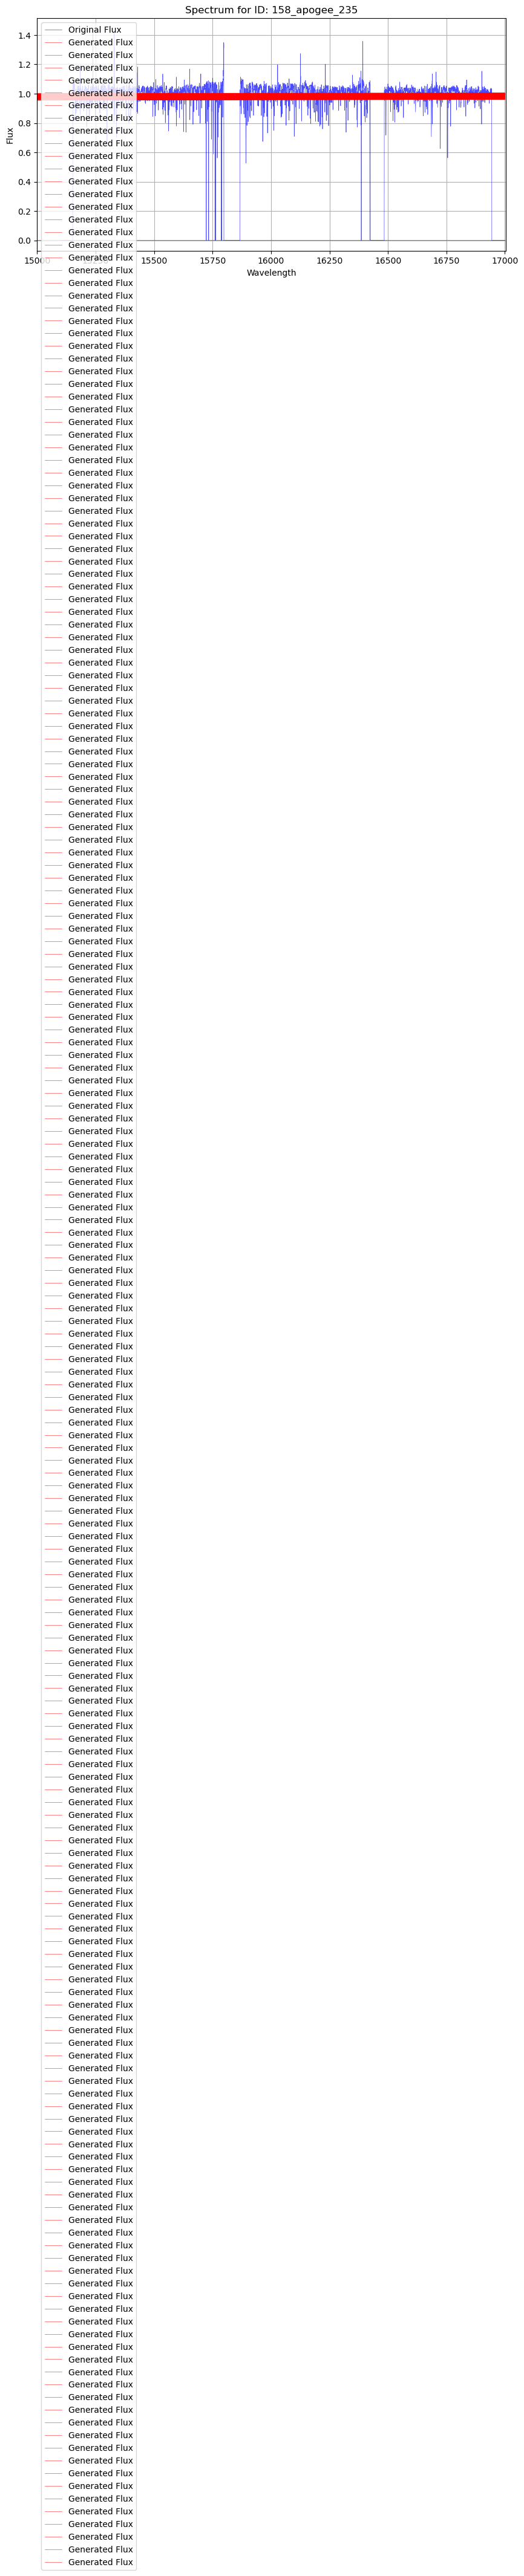

In [11]:
for batch in data_loader_full_spectra:
    generated_spectra, valid_ids = generate_full_spectra(generator, latent_codes, batch)
    plot_spectra(batch, generated_spectra, valid_ids, num_spectra=1)
    break  # Only process the first batch